In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import datetime
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_theme()
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset, random_split

In [3]:
repo_path = '/content/drive/MyDrive/odeformer' # folder where odeformer is stored
script_path = '/content/drive/MyDrive/aisc' # folder containing the script generate_samples.py
activations_path = '/content/drive/MyDrive/aisc/activations' # where you want to save activations
logs_path = '/content/drive/MyDrive/aisc/logs'
probes_path = '/content/drive/MyDrive/aisc/probes'
%cd {script_path}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/content/drive/MyDrive/aisc


# LRProbe and ActivationsDataset classes

In [4]:
# Probe class

class LRProbe(torch.nn.Module):
    def __init__(self, d_in=512): # Default decoder layer activation dimension
        super(LRProbe, self).__init__()
        self.hidden = torch.nn.Linear(d_in, 1, bias=False)

    def forward(self, x):
        x = self.hidden(x)
        x = x.squeeze(-1)
        return x

    def predict(self, acts):
        with torch.no_grad():
            return self(acts)

    def direction(self):
        return self.hidden.weight.data[0]

In [5]:
# PyTorch wrapper for activations dataset

class ActivationsDataset(Dataset):
  def __init__(self, activations_path, feature_label, layer_idx, module='ffn'):
    self.act_paths = [os.path.join(activations_path, f) for f in os.listdir(activations_path)]
    self.feature_label = feature_label
    self.layer_idx = layer_idx
    self.module = module

  def __len__(self):
    return len(self.act_paths)

  def __getitem__(self, idx):
    act_path = self.act_paths[idx]
    with open(act_path, 'rb') as f:
      activation = pickle.load(f)
    layer_name = self.get_layer_name(self.layer_idx)
    if 'encoder' in layer_name:
      act_data = activation['encoder'][layer_name]
    else:
      act_data = activation['decoder'][layer_name]
    # TODO: need to update the below functionality to be neater (needs to work with activation generation script)
    if act_data.shape[0] != 512: # TODO: need to update this for when we consider multiple beams
      act_data = act_data[-1, :, :].flatten()
    act_label = torch.tensor(activation['feature_dict'][self.feature_label], dtype=torch.float)
    return act_data, act_label

  def get_layer_name(self, idx):
    '''
    Helper function to return the correct name of a layer in the ODEFormer given
    its index
    '''
    layers = [f'encoder_{self.module}_{num}' for num in range(4)] + [f'decoder_{self.module}_{num}' for num in range(12)]
    layer_name = layers[idx]
    if -16 <= idx < 16:
      return layer_name
    else:
      raise ValueError("Layer index should be in -16 to 15")

# Helper functions

In [6]:
# Dataset helper functions

def split_dataset(dataset, lengths=[0.8, 0.0, 0.2], seed=None):
  '''
  Split into training, validation, and testing datasets
  Default is to have no validation dataset (i.e. empty) and randomized splitting
  Seed can be set for deterministic splitting
  '''
  if seed is not None:
    generator = torch.Generator().manual_seed(seed)
  else:
    generator = torch.Generator()
  return random_split(dataset, lengths, generator)

def get_d_in(dataset):
  '''
  Return the input dimension a probe requires for a given dataset of activations
  '''
  d_in = dataset[0][0].shape[0]
  return d_in

In [7]:
# Probe training and evaluation functions

def eval_probe(probe, dataloader):
  '''
  Evaluate a given probe on a specified dataset (via its corresponding dataloader)
  '''
  with torch.no_grad():
    total_loss = 0
    correct = 0
    total_preds = 0
    criterion = nn.BCEWithLogitsLoss()

    probe.eval()

    for acts, labels in dataloader:
      outputs = probe(acts)
      loss = criterion(outputs, labels)
      total_loss += loss.item()

      pred_labels = torch.nn.functional.sigmoid(outputs).round()
      correct += (pred_labels == labels).float().sum()
      total_preds += len(labels)

    accuracy = (correct / total_preds).item()
    avg_loss = total_loss / total_preds
    return avg_loss, accuracy

def train_probe(probe, train_dataloader, val_dataloader=None, \
                lr=0.01, num_epochs=20, device='cpu', \
                logs_path='/content/drive/MyDrive/aisc/logs', write_log=False): # TODO: determine if default hyperparameters are good
  '''
  Train an instantiated probe using specified training and validation data
  '''
  # Use Adam optimizer for now
  # TODO: determine if other optimizers might be better
  # TODO: investigate adding learning rate scheduler (e.g. cosine annealing?)
  opt = optim.Adam(probe.parameters(), lr=lr, weight_decay=1e-3)
  # TODO: investigate if weight decay is actually necessary
  criterion = nn.BCEWithLogitsLoss()

  # Open log files to write to if desired
  # Include the current time of the experiment in filename to avoid collisions
  today_str = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M')
  if write_log:
    train_f = open(os.path.join(logs_path, f'{today_str}_train_acc_per_epoch.txt'), 'w')
    train_f.write(f'Learning rate: {lr}, Num. epochs: {num_epochs}\n')
    if val_dataloader is not None:
      val_f = open(os.path.join(logs_path, f'{today_str}_val_acc_per_epoch.txt'), 'w')
      val_f.write(f'Learning rate: {lr}, Num. epochs: {num_epochs}\n')

  losses = []
  accuracies = []
  val_losses = []
  val_accuracies = []

  # Epoch 0 (for comparison against epoch 1)
  e0_train_loss, e0_train_acc = eval_probe(probe, train_dataloader)
  losses.append(e0_train_loss)
  accuracies.append(e0_train_acc)
  if val_dataloader is not None:
    e0_val_loss, e0_val_acc = eval_probe(probe, val_dataloader)
    val_losses.append(e0_val_loss)
    val_accuracies.append(e0_val_acc)

  # Main training loop
  for epoch in tqdm(range(num_epochs), desc='Training LR Probe'):
    probe.train()
    total_loss = 0
    correct_preds = 0
    total_preds = 0

    for i, (train_acts, train_labels) in enumerate(train_dataloader):
      # Zero the gradients
      opt.zero_grad()

      # Calculate loss
      outputs = probe(train_acts)
      loss = criterion(outputs, train_labels)

      loss.backward()

      # Update model weights
      opt.step()

      total_loss += loss.item()
      total_preds += len(train_labels)

      # Calculate correct batch predictions
      # preds = outputs.round()
      pred_labels = torch.nn.functional.sigmoid(outputs).round()
      correct_preds += (pred_labels == train_labels).float().sum()

    # Calculate epoch stats
    accuracy = (correct_preds / total_preds).item()
    avg_loss = total_loss / total_preds

    losses.append(avg_loss)
    accuracies.append(accuracy)

    # Write to specified log file
    if write_log:
      train_f.write(f'Epoch {epoch+1}: Loss {avg_loss}, Accuracy {accuracy}\n')
    # print(f' Epoch {epoch+1}: Loss {avg_loss}, Accuracy {accuracy.item()}\n')

    # Run evaluation on validation set
    # TODO: maybe implement early stopping? Need to test on larger dataset
    if val_dataloader is not None:
        avg_val_loss, val_accuracy = eval_probe(probe, val_dataloader)

        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        if write_log:
          val_f.write(f'Epoch {epoch+1} (Validation): Loss {avg_val_loss}, Accuracy {val_accuracy}\n')
        # print(f' Epoch {epoch+1} (Validation): Loss {avg_val_loss}, Accuracy {val_accuracy.item()}\n')
  print(f'\nEpoch {epoch+1} (Final): Loss {avg_loss}, Accuracy {accuracy}')

  return probe, losses, accuracies, val_losses, val_accuracies

In [8]:
# Probe saving and loading functionality

def save_probe_to_path(probe, probe_path):
  '''
  Save a probe's state dictionary to a specified path
  (saving only the state dictionary is suggested by PyTorch)
  '''
  torch.save(probe.state_dict(), probe_path)
  print(f'Saved state dictionary to {probe_path}')

def load_probe_from_path(probe_path, d_in=512):
  '''
  Returns a probe ready for evaluation loaded from the given path, with specified input dimension
  '''
  probe = LRProbe(d_in=d_in)
  probe.load_state_dict(torch.load(probe_path, weights_only=True))
  probe.eval()
  return probe

In [9]:
# Plotting functionality

def plot_data(data, val_data, num_epochs, data_name, use_val, include_e0):
  # TODO: add saving flag and directory for plots
  # Changed to include epoch 0 (random init performance)
  fig, ax = plt.subplots()
  if include_e0:
    start_idx = 0
  else:
    start_idx = 1
  epochs = torch.arange(start_idx, num_epochs + 1, step=1).to(torch.int)
  ax.plot(epochs, data[start_idx:], marker='x', color='tab:blue', label='Training')
  including_string = 'with' if include_e0 else 'without'
  ax.set(title=f'{data_name} ({including_string} epoch 0)', xlabel='Epoch', ylabel=data_name)
  if use_val:
    ax.plot(epochs, val_data[start_idx:], marker='x', color='tab:orange', label='Validation')
    ax.legend()
  plt.show()

In [10]:
# # MWE and features testing

# # Test dataset, dataloaders, and splitting
# target_feature = 'trig'
# target_layer_idx = 15
# full_dataset = ActivationsDataset(activations_path=activations_path, feature_label=target_feature, layer_idx=target_layer_idx)
# train_dataset, val_dataset, test_dataset = split_dataset(full_dataset, lengths=[0.7, 0.1, 0.2], seed=42)
# train_dataloader = DataLoader(train_dataset)
# val_dataloader = DataLoader(val_dataset)
# test_dataloader = DataLoader(test_dataset)

# # Test helper function and probe
# d_in = get_d_in(full_dataset)
# test_probe = LRProbe(d_in)

# # Test training loop
# test_probe, losses, accuracies, val_losses, val_accuracies = train_probe(test_probe, train_dataloader, val_dataloader=val_dataloader)

# # Test evaluation function on test set
# test_loss, test_acc = eval_probe(test_probe, test_dataloader)
# print(f'Test Set: Loss {test_loss}, Accuracy {test_acc}')

# # Test extracting saved probe direction
# print(f'Probe direction dim: {test_probe.direction.shape}')

# # Test saving and loading probe
# probe_name = f'test_probe_{target_feature}_{target_layer_idx}.pt'
# test_probe_path = os.path.join(probes_path, probe_name)
# save_probe_to_path(test_probe, test_probe_path)
# test_probe_copy = load_probe_from_path(test_probe_path, d_in=d_in)

In [11]:
# # More advanced tests

# man_activations_path = '/content/drive/MyDrive/aisc/activations_manual_singlebeam'

# # Test dataset, dataloaders, and splitting
# target_feature = 'exponential_decay'
# target_layer_idx = -1
# num_epochs = 20
# lr = 0.001
# shuffle_datasets = True
# write_data = False
# use_val = True
# full_dataset = ActivationsDataset(activations_path=man_activations_path, feature_label=target_feature, layer_idx=target_layer_idx)
# train_dataset, val_dataset, test_dataset = split_dataset(full_dataset, lengths=[0.8, 0.1, 0.1])
# train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=shuffle_datasets)
# if use_val:
#   val_dataloader = DataLoader(val_dataset, shuffle=shuffle_datasets)
# test_dataloader = DataLoader(test_dataset, shuffle=shuffle_datasets)

# # Test helper function and probe
# d_in = get_d_in(full_dataset)
# test_probe = LRProbe(d_in)

# # Test training loop
# if use_val:
#   test_probe, losses, accuracies, val_losses, val_accuracies = train_probe(test_probe, train_dataloader, lr=lr, write_log=write_data, num_epochs=num_epochs, val_dataloader=val_dataloader)
# else:
#   test_probe, losses, accuracies, val_losses, val_accuracies = train_probe(test_probe, train_dataloader, lr=lr, write_log=write_data, num_epochs=num_epochs)

# # Test evaluation function on test set
# test_loss, test_acc = eval_probe(test_probe, test_dataloader)
# print(f'Test Set: Loss {test_loss}, Accuracy {test_acc}')

# # Test extracting saved probe direction
# # print(f'Probe direction dim: {test_probe.direction().shape}')
# # print(f'Probe direction: {test_probe.direction()}')

# # Test saving and loading probe
# if write_data:
#   probe_name = f'test_probe_{target_feature}_{target_layer_idx}.pt'
#   test_probe_path = os.path.join(probes_path, probe_name)
#   save_probe_to_path(test_probe, test_probe_path)
#   # test_probe_copy = load_probe_from_path(test_probe_path, d_in=d_in)

In [12]:
# plot_data(losses, val_losses, num_epochs, 'Loss', use_val, include_e0=True)

In [13]:
# plot_data(losses, val_losses, num_epochs, 'Loss', use_val, include_e0=False)

In [14]:
# plot_data(accuracies, val_accuracies, num_epochs, 'Accuracy', use_val, include_e0=True)

In [15]:
# plot_data(accuracies, val_accuracies, num_epochs, 'Accuracy', use_val, include_e0=False)

In [16]:
def train_and_save_probe_separation_expt(target_layer_idx, target_feature, lr, num_epochs, probe_name):
  man_activations_path = '/content/drive/MyDrive/aisc/activations_manual_singlebeam'

  # Test dataset, dataloaders, and splitting
  shuffle_datasets = True
  write_data = True
  use_val = True
  full_dataset = ActivationsDataset(activations_path=man_activations_path, feature_label=target_feature, layer_idx=target_layer_idx)
  train_dataset, val_dataset, test_dataset = split_dataset(full_dataset, lengths=[0.8, 0.1, 0.1])
  train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=shuffle_datasets)
  if use_val:
    val_dataloader = DataLoader(val_dataset, shuffle=shuffle_datasets)
  test_dataloader = DataLoader(test_dataset, shuffle=shuffle_datasets)

  # Test helper function and probe
  d_in = get_d_in(full_dataset)
  test_probe = LRProbe(d_in)

  # Training loop
  if use_val:
    test_probe, losses, accuracies, val_losses, val_accuracies = train_probe(test_probe, train_dataloader, lr=lr, write_log=write_data, num_epochs=num_epochs, val_dataloader=val_dataloader)
  else:
    test_probe, losses, accuracies, val_losses, val_accuracies = train_probe(test_probe, train_dataloader, lr=lr, write_log=write_data, num_epochs=num_epochs)

  # Evaluation on test set
  test_loss, test_acc = eval_probe(test_probe, test_dataloader)
  print(f'\nProbe trained on layer {target_layer_idx}:')
  print(f'Test Set: Loss {test_loss}, Accuracy {test_acc}')

  # Save probe
  test_probe_path = os.path.join(probes_path, probe_name)
  save_probe_to_path(test_probe, test_probe_path)

  return test_loss, test_acc

In [17]:
'''
What do we want to do here?
Starting from the first decoder layer, we want to analyse performance on the
test set of probes trained on each layer (given the same beam)
- So we need to train a probe for each layer, given the same feature label
- Then, given each of these probes, we need to analyse their performance on the
  test set
- Then we want to plot the test accuracy as we move to later decoder layers
- At some point, we will want AUROC for different probes as well
'''

def separability_testing(target_feature, lr, num_epochs, layers, num_repeats=1):
  experiment_data = []

  for layer_idx in layers:
    for run in range(num_repeats):
      probe_name = f'test_probe_{target_feature}_{layer_idx}_{run}.pt'
      test_loss, test_acc = train_and_save_probe_separation_expt(layer_idx, target_feature, lr, num_epochs, probe_name)
      experiment_data.append({
            "layer": layer_idx,
            "run": run,
            "accuracy": test_acc,
            "loss": test_loss
        })

  experiment_data = pd.DataFrame(data=experiment_data)

  return experiment_data

In [18]:
target_feature = 'exponential_decay'
lr = 0.001
num_epochs = 1 # TODO: change back to a higher number once finished testing
num_repeats = 2 # TODO: change back to a higher number once finished testing
layers = [idx for idx in range(4, 16)]

experiment_data = separability_testing(target_feature, lr, num_epochs, layers, num_repeats)

Training LR Probe: 100%|██████████| 1/1 [00:05<00:00,  5.09s/it]



Epoch 1 (Final): Loss 0.03285180496331568, Accuracy 0.8781869411468506

Probe trained on layer 4:
Test Set: Loss 0.1637773353665558, Accuracy 0.9431818127632141
Saved state dictionary to /content/drive/MyDrive/aisc/probes/test_probe_exponential_decay_4_0.pt


Training LR Probe: 100%|██████████| 1/1 [00:05<00:00,  5.08s/it]



Epoch 1 (Final): Loss 0.01980410352307728, Accuracy 0.902266263961792

Probe trained on layer 4:
Test Set: Loss 0.3535213733139763, Accuracy 0.8068181872367859
Saved state dictionary to /content/drive/MyDrive/aisc/probes/test_probe_exponential_decay_4_1.pt


Training LR Probe: 100%|██████████| 1/1 [00:04<00:00,  4.68s/it]



Epoch 1 (Final): Loss 0.0391293680585562, Accuracy 0.8356940746307373

Probe trained on layer 5:
Test Set: Loss 0.20237869530278285, Accuracy 0.9318181872367859
Saved state dictionary to /content/drive/MyDrive/aisc/probes/test_probe_exponential_decay_5_0.pt


Training LR Probe: 100%|██████████| 1/1 [00:04<00:00,  4.84s/it]



Epoch 1 (Final): Loss 0.04968334345157567, Accuracy 0.8385269045829773

Probe trained on layer 5:
Test Set: Loss 0.24698780806201473, Accuracy 0.9090909361839294
Saved state dictionary to /content/drive/MyDrive/aisc/probes/test_probe_exponential_decay_5_1.pt


Training LR Probe: 100%|██████████| 1/1 [00:04<00:00,  4.81s/it]



Epoch 1 (Final): Loss 0.019093642755287566, Accuracy 0.9008498787879944

Probe trained on layer 6:
Test Set: Loss 0.19453909975319758, Accuracy 0.9431818127632141
Saved state dictionary to /content/drive/MyDrive/aisc/probes/test_probe_exponential_decay_6_0.pt


Training LR Probe: 100%|██████████| 1/1 [00:04<00:00,  4.78s/it]



Epoch 1 (Final): Loss 0.016707030285899094, Accuracy 0.9206798672676086

Probe trained on layer 6:
Test Set: Loss 0.26348842133209094, Accuracy 0.9318181872367859
Saved state dictionary to /content/drive/MyDrive/aisc/probes/test_probe_exponential_decay_6_1.pt


Training LR Probe: 100%|██████████| 1/1 [00:04<00:00,  4.88s/it]



Epoch 1 (Final): Loss 0.04195784146319705, Accuracy 0.6728045344352722

Probe trained on layer 7:
Test Set: Loss 0.6063259416683153, Accuracy 0.6136363744735718
Saved state dictionary to /content/drive/MyDrive/aisc/probes/test_probe_exponential_decay_7_0.pt


Training LR Probe: 100%|██████████| 1/1 [00:04<00:00,  4.98s/it]



Epoch 1 (Final): Loss 0.04099257387453031, Accuracy 0.6954674124717712

Probe trained on layer 7:
Test Set: Loss 0.5918086435307156, Accuracy 0.9204545617103577
Saved state dictionary to /content/drive/MyDrive/aisc/probes/test_probe_exponential_decay_7_1.pt


Training LR Probe: 100%|██████████| 1/1 [00:04<00:00,  4.97s/it]



Epoch 1 (Final): Loss 0.022298543505560577, Accuracy 0.8937677145004272

Probe trained on layer 8:
Test Set: Loss 0.23514052117984233, Accuracy 0.9204545617103577
Saved state dictionary to /content/drive/MyDrive/aisc/probes/test_probe_exponential_decay_8_0.pt


Training LR Probe: 100%|██████████| 1/1 [00:04<00:00,  4.84s/it]



Epoch 1 (Final): Loss 0.025112574439886272, Accuracy 0.821529746055603

Probe trained on layer 8:
Test Set: Loss 0.2510790306524458, Accuracy 0.9204545617103577
Saved state dictionary to /content/drive/MyDrive/aisc/probes/test_probe_exponential_decay_8_1.pt


Training LR Probe: 100%|██████████| 1/1 [00:04<00:00,  4.72s/it]



Epoch 1 (Final): Loss 0.014129184756333023, Accuracy 0.9263455867767334

Probe trained on layer 9:
Test Set: Loss 0.11319807496990754, Accuracy 0.9318181872367859
Saved state dictionary to /content/drive/MyDrive/aisc/probes/test_probe_exponential_decay_9_0.pt


Training LR Probe: 100%|██████████| 1/1 [00:05<00:00,  5.00s/it]



Epoch 1 (Final): Loss 0.01635101286921302, Accuracy 0.8852691054344177

Probe trained on layer 9:
Test Set: Loss 0.12569058367146432, Accuracy 0.9318181872367859
Saved state dictionary to /content/drive/MyDrive/aisc/probes/test_probe_exponential_decay_9_1.pt


Training LR Probe: 100%|██████████| 1/1 [00:04<00:00,  4.74s/it]



Epoch 1 (Final): Loss 0.015228998124409499, Accuracy 0.8866855502128601

Probe trained on layer 10:
Test Set: Loss 0.11916660267293495, Accuracy 0.9431818127632141
Saved state dictionary to /content/drive/MyDrive/aisc/probes/test_probe_exponential_decay_10_0.pt


Training LR Probe: 100%|██████████| 1/1 [00:04<00:00,  4.69s/it]



Epoch 1 (Final): Loss 0.015854940892173448, Accuracy 0.8895184397697449

Probe trained on layer 10:
Test Set: Loss 0.10853412385635734, Accuracy 0.9431818127632141
Saved state dictionary to /content/drive/MyDrive/aisc/probes/test_probe_exponential_decay_10_1.pt


Training LR Probe: 100%|██████████| 1/1 [00:04<00:00,  4.76s/it]



Epoch 1 (Final): Loss 0.012309179761349395, Accuracy 0.9291784763336182

Probe trained on layer 11:
Test Set: Loss 0.07477964641822671, Accuracy 0.9659090638160706
Saved state dictionary to /content/drive/MyDrive/aisc/probes/test_probe_exponential_decay_11_0.pt


Training LR Probe: 100%|██████████| 1/1 [00:04<00:00,  4.71s/it]



Epoch 1 (Final): Loss 0.010190137531397279, Accuracy 0.9419263601303101

Probe trained on layer 11:
Test Set: Loss 0.07369372077201577, Accuracy 0.9659090638160706
Saved state dictionary to /content/drive/MyDrive/aisc/probes/test_probe_exponential_decay_11_1.pt


Training LR Probe: 100%|██████████| 1/1 [00:05<00:00,  5.04s/it]



Epoch 1 (Final): Loss 0.011984093288861996, Accuracy 0.9178470373153687

Probe trained on layer 12:
Test Set: Loss 0.09250056173715909, Accuracy 0.9659090638160706
Saved state dictionary to /content/drive/MyDrive/aisc/probes/test_probe_exponential_decay_12_0.pt


Training LR Probe: 100%|██████████| 1/1 [00:05<00:00,  5.11s/it]



Epoch 1 (Final): Loss 0.011092624708841273, Accuracy 0.9390934705734253

Probe trained on layer 12:
Test Set: Loss 0.07727404267908158, Accuracy 0.9431818127632141
Saved state dictionary to /content/drive/MyDrive/aisc/probes/test_probe_exponential_decay_12_1.pt


Training LR Probe: 100%|██████████| 1/1 [00:04<00:00,  5.00s/it]



Epoch 1 (Final): Loss 0.022845095598663892, Accuracy 0.8342776298522949

Probe trained on layer 13:
Test Set: Loss 0.1224927311995998, Accuracy 0.9431818127632141
Saved state dictionary to /content/drive/MyDrive/aisc/probes/test_probe_exponential_decay_13_0.pt


Training LR Probe: 100%|██████████| 1/1 [00:04<00:00,  4.70s/it]



Epoch 1 (Final): Loss 0.020670971566700395, Accuracy 0.8838527202606201

Probe trained on layer 13:
Test Set: Loss 0.12202632744711908, Accuracy 0.9545454382896423
Saved state dictionary to /content/drive/MyDrive/aisc/probes/test_probe_exponential_decay_13_1.pt


Training LR Probe: 100%|██████████| 1/1 [00:04<00:00,  4.64s/it]



Epoch 1 (Final): Loss 0.023246965437029983, Accuracy 0.8597733974456787

Probe trained on layer 14:
Test Set: Loss 0.19745161255228927, Accuracy 0.9204545617103577
Saved state dictionary to /content/drive/MyDrive/aisc/probes/test_probe_exponential_decay_14_0.pt


Training LR Probe: 100%|██████████| 1/1 [00:04<00:00,  4.87s/it]



Epoch 1 (Final): Loss 0.02599594952068991, Accuracy 0.8257790207862854

Probe trained on layer 14:
Test Set: Loss 0.21300337829796429, Accuracy 0.9204545617103577
Saved state dictionary to /content/drive/MyDrive/aisc/probes/test_probe_exponential_decay_14_1.pt


Training LR Probe: 100%|██████████| 1/1 [00:04<00:00,  4.87s/it]



Epoch 1 (Final): Loss 0.02932568417898994, Accuracy 0.821529746055603

Probe trained on layer 15:
Test Set: Loss 0.14493930583094797, Accuracy 0.9545454382896423
Saved state dictionary to /content/drive/MyDrive/aisc/probes/test_probe_exponential_decay_15_0.pt


Training LR Probe: 100%|██████████| 1/1 [00:04<00:00,  4.78s/it]



Epoch 1 (Final): Loss 0.018601944158249468, Accuracy 0.8937677145004272

Probe trained on layer 15:
Test Set: Loss 0.14668332319243663, Accuracy 0.9204545617103577
Saved state dictionary to /content/drive/MyDrive/aisc/probes/test_probe_exponential_decay_15_1.pt


In [19]:
experiment_data

,layer,run,accuracy,loss
0,4,0,0.943182,0.163777
1,4,1,0.806818,0.353521
2,5,0,0.931818,0.202379
3,5,1,0.909091,0.246988
4,6,0,0.943182,0.194539
5,6,1,0.931818,0.263488
6,7,0,0.613636,0.606326
7,7,1,0.920455,0.591809
8,8,0,0.920455,0.235141
9,8,1,0.920455,0.251079


In [20]:
experiment_summary = experiment_data.groupby("layer").agg(
    accuracy_mean=("accuracy", "mean"),
    accuracy_std=("accuracy", "std"),
    loss_mean=("loss", "mean"),
    loss_std=("loss", "std")
).reset_index()

In [21]:
experiment_summary

,layer,accuracy_mean,accuracy_std,loss_mean,loss_std
0,4,0.875000,0.096424,0.258649,0.134169
1,5,0.920455,0.016071,0.224683,0.031543
2,6,0.937500,0.008035,0.229014,0.048755
3,7,0.767045,0.216953,0.599067,0.010265
4,8,0.920455,0.000000,0.243110,0.011270
5,9,0.931818,0.000000,0.119444,0.008834
6,10,0.943182,0.000000,0.113850,0.007518
7,11,0.965909,0.000000,0.074237,0.000768
8,12,0.954545,0.016071,0.084887,0.010767
9,13,0.948864,0.008035,0.122260,0.000330


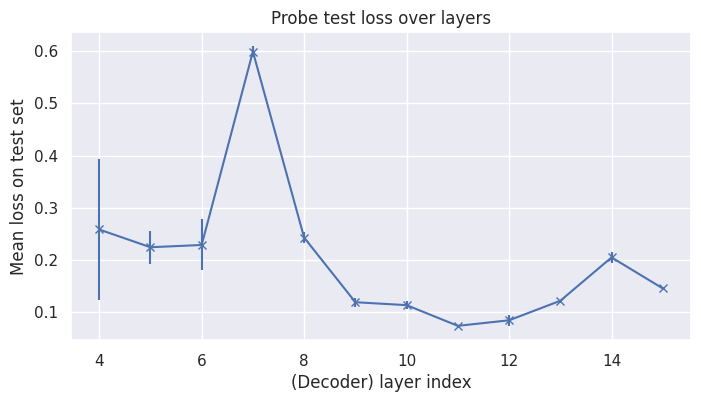

In [22]:
fig, ax = plt.subplots(figsize=(8,4))
ax.errorbar(layers, experiment_summary['loss_mean'], yerr=experiment_summary['loss_std'], marker='x')
ax.set(title='Probe test loss over layers', xlabel='(Decoder) layer index', ylabel='Mean loss on test set')
plt.show()

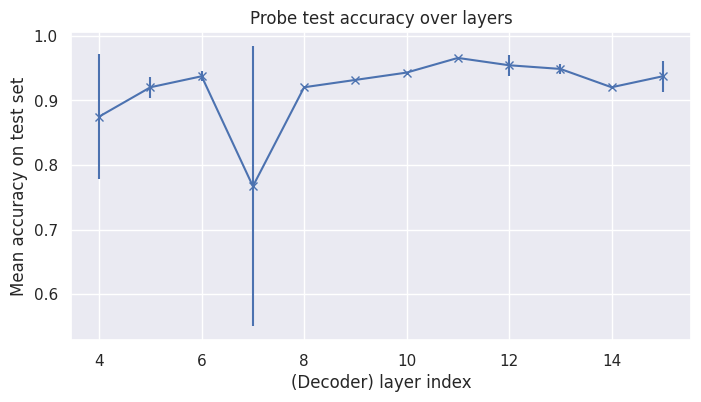

In [23]:
fig, ax = plt.subplots(figsize=(8,4))
ax.errorbar(layers, experiment_summary['accuracy_mean'], yerr=experiment_summary['accuracy_std'], marker='x')
ax.set(title='Probe test accuracy over layers', xlabel='(Decoder) layer index', ylabel='Mean accuracy on test set')
plt.show()